<a href="https://colab.research.google.com/github/auroramugnai/arXiv_classification/blob/main/arXiv_classification/category_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/auroramugnai/arXiv_classification.git
%cd arXiv_classification
%ls

Cloning into 'arXiv_classification'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 32 (delta 11), reused 8 (delta 2), pack-reused 0
Receiving objects: 100% (32/32), 995.41 KiB | 6.59 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/arXiv_classification
arXiv_classification/  LICENSE  README.md


# 1) Create the dataset

Install & import

In [ ]:
# !pip install kaggle -q
# !pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
import os
import json
import zipfile
import dask.bag as db # use this library to import big dimension datset
import pandas as pd

import random
import matplotlib.pyplot as plt

## Download the dataset
Before excecuting:

- Log in into kaggle.
- Go to your profile settings -> "create a new token".
- The key will be downloaded on your local machine in a JSON file named "kaggle.json"

Now:
- Open your Google Drive account.
- Create a new folder named "kaggle".
- Upload the kaggle.json file to the "kaggle" folder.


In [4]:
# os.environ['KAGGLE_CONFIG_DIR'] = '/content/arXiv_classification'

Going to https://www.kaggle.com/datasets/Cornell-University/arxiv and clicking on "Copy API command",
we get the following line of code that enables us to download the dataset.

In [6]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
100% 1.27G/1.28G [00:13<00:00, 112MB/s]
100% 1.28G/1.28G [00:13<00:00, 98.1MB/s]


Unzip the downloaded file.

In [8]:
path = '/content/arXiv_classification/arxiv.zip'

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('/content/arXiv_classification/kaggle')  # Replace with your desired folder

The unzipping creates an "arxiv-metadata-oai-snapshot.json" (big!) file that now we can easily read.

In [10]:
# Create a dask bag.
path = "/content/arXiv_classification/kaggle/arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)
arxiv_data.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## Keep only useful information
We get rid of some unnecessary infomation and keep only the articles whose latest version is after 2022.

In [ ]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).map(cut_info).compute())


# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
df.to_csv("/content/drive/MyDrive/arxiv_data_filtered.csv", index=False)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"[math.NA, cs.NA]",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,[physics.gen-ph],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"[math.AC, math.GM, math.NT, math.RA]",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","[math.AG, math.NT]","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,[math.NT],We show a generalization of Mason's ABC-theo...


## Balance the dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/arxiv_data_filtered.csv", dtype=str)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"['math.NA', 'cs.NA']",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,['physics.gen-ph'],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"['math.AC', 'math.GM', 'math.NT', 'math.RA']",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","['math.AG', 'math.NT']","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,['math.NT'],We show a generalization of Mason's ABC-theo...


Useful functions

In [ ]:
from utils import *

Set a minimum and maximum threshold for category counts. N.B.: we are referring to category list counts and not single category counts!

In [ ]:
num_min = 300
num_max = num_min + 100

categories_as_strings(df)

# drop the categories that have less than num_min counts.
cut_num_min = lambda x : len(x) > num_min
df = df.groupby('category').filter(cut_num_min)

# sample num_max times those categories that have more than num_max counts.
sample_num_max = lambda x: x.sample(min(len(x), num_max))
df = df.groupby('category', as_index = False, group_keys=False)
df = df.apply(sample_num_max).reset_index(drop=True)

print(f"The dataset contains {len(df)} articles.")
df.head()

The dataset contains 63005 articles.


,id,title,category,abstract
0,2212.08056,A multi-tracer empirically-driven approach to ...,"['astro-ph.CO', 'astro-ph.GA']",Line-intensity mapping (LIM) is an emerging ...
1,2310.11502,Modeling Post-Reionization HI Distributions in...,"['astro-ph.CO', 'astro-ph.GA']",Upcoming 21 cm intensity mapping experiments...
2,2306.03127,Improved Modeling of the Kinematic Sunyaev-Zel...,"['astro-ph.CO', 'astro-ph.GA']","Over the past decade, the kinematic Sunyaev-..."
3,2310.03077,On the ellipticity parameterization for an NFW...,"['astro-ph.CO', 'astro-ph.GA']",Galaxy-scale gravitational lenses are often ...
4,2309.05758,Zero Metallicity with Zero CPU Hours: Masses o...,"['astro-ph.CO', 'astro-ph.GA']",We develop an analytic model for the mass of...


Keep only num_cat randomly chosen categories. Be sure that only those categories appear in the lists!

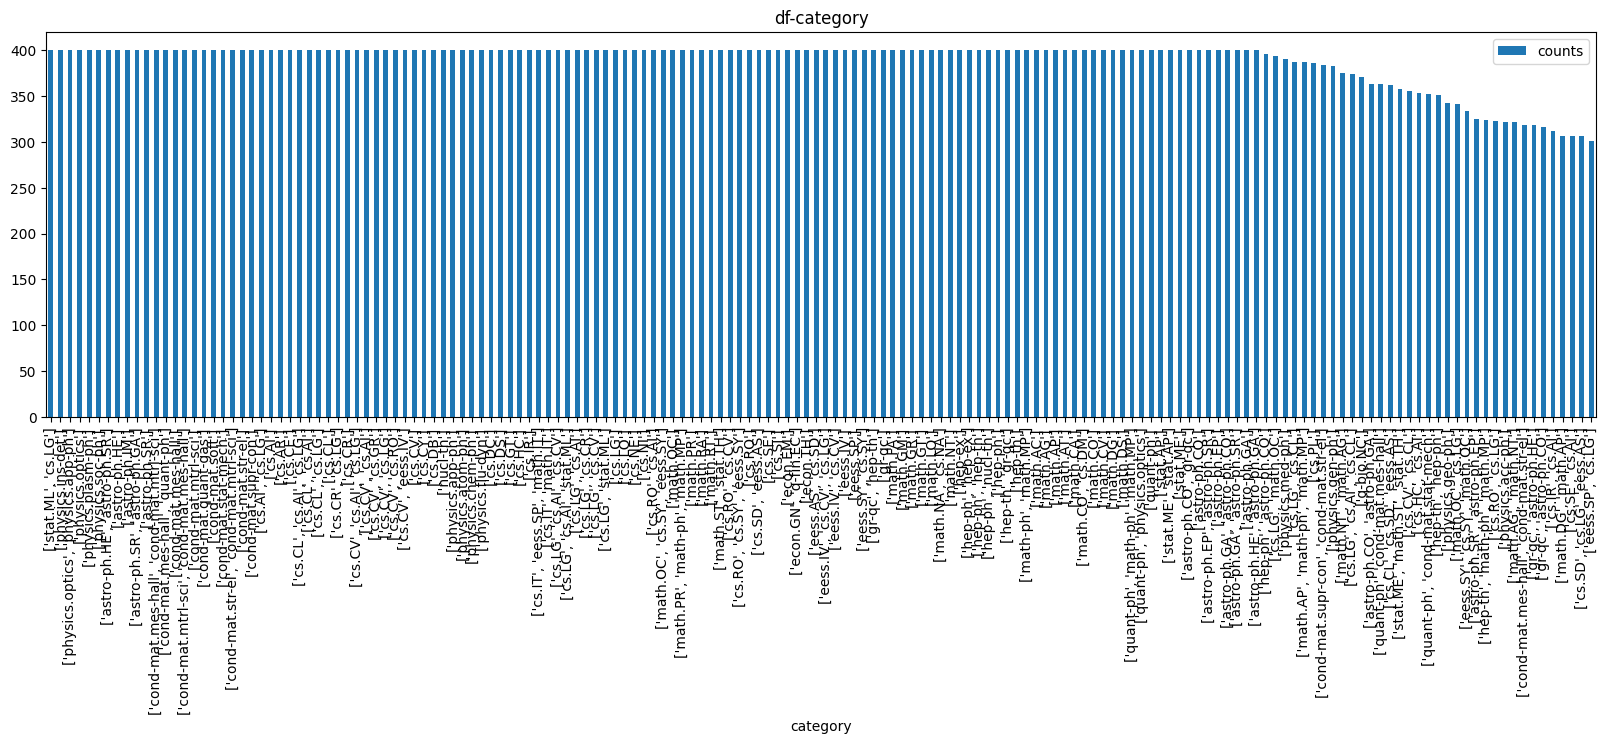

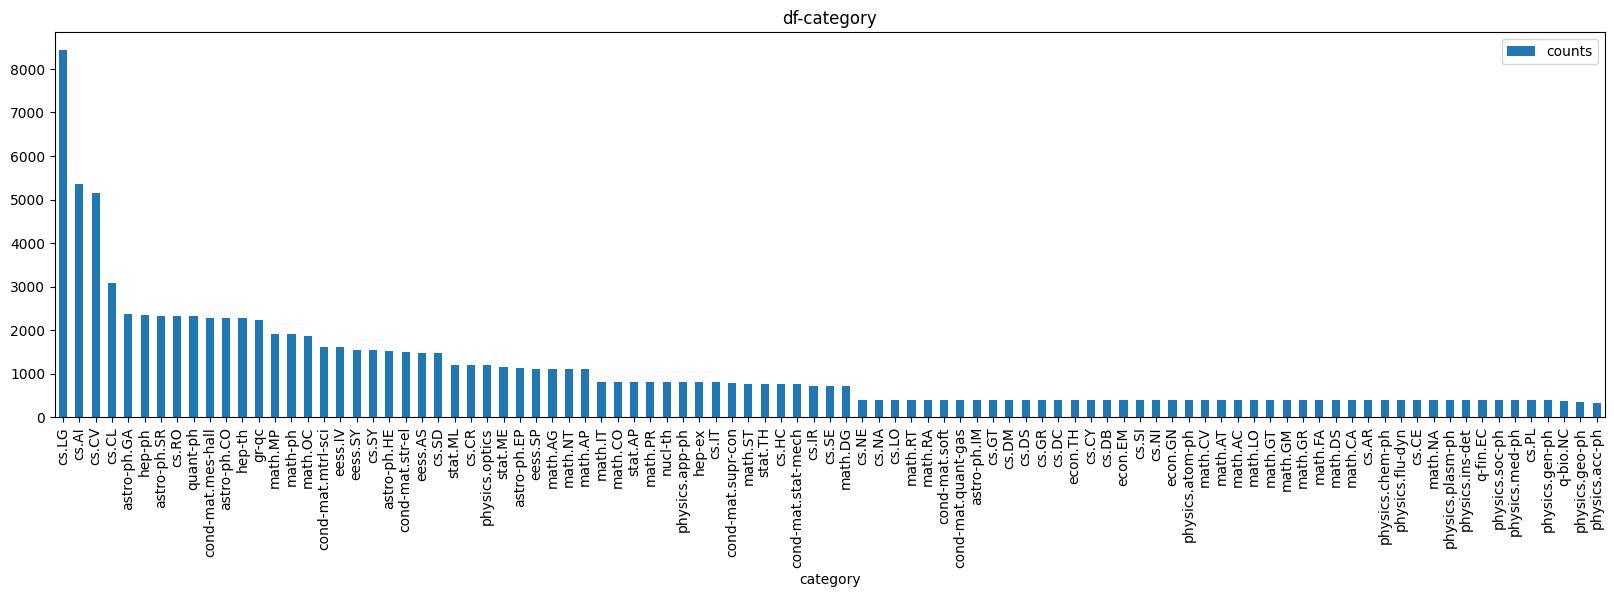

In [ ]:
### Counts lists of categories ###
categories_as_strings(df)
_ = plot_df_counts(df, col="category")


### Counts single categories ###
categories_as_lists(df)
df_exp = df.explode("category")
dict_counts_exp = plot_df_counts(df_exp, col="category")
files.download("abc.png")

In [ ]:
# get all the categories
C  = list(dict_counts_exp.keys())
print(f'Number of categories appearing in the dataset: {len(C)}')

# take a subset
sub_C = random.sample(C, 20)
print(f'Number of categories appearing in the dataset: {len(sub_C)}')

# the elements must be lists of strings and not strings!
categories_as_lists(df)

# take only the articles that have at least one occurence of one of the selected categories.
df = df.loc[df['category'].explode().isin(sub_C).loc[lambda x: x].index]
df.head()

Number of categories appearing in the dataset: 95
Number of categories appearing in the dataset: 20


,id,title,category,abstract
0,2212.08056,A multi-tracer empirically-driven approach to ...,"[astro-ph.CO, astro-ph.GA]",Line-intensity mapping (LIM) is an emerging ...
1,2310.11502,Modeling Post-Reionization HI Distributions in...,"[astro-ph.CO, astro-ph.GA]",Upcoming 21 cm intensity mapping experiments...
2,2306.03127,Improved Modeling of the Kinematic Sunyaev-Zel...,"[astro-ph.CO, astro-ph.GA]","Over the past decade, the kinematic Sunyaev-..."
3,2310.03077,On the ellipticity parameterization for an NFW...,"[astro-ph.CO, astro-ph.GA]",Galaxy-scale gravitational lenses are often ...
4,2309.05758,Zero Metallicity with Zero CPU Hours: Masses o...,"[astro-ph.CO, astro-ph.GA]",We develop an analytic model for the mass of...


## Randomly sample the dataset to get a fixed number of articles
To get a fixed number of articles (to avoid session crash!)

In [ ]:
num_data = 20000 # number of articles that we want to keep
print(f"The dataset contains {len(df)} articles.")

# Sample the dataset only if its length exceeds num_data
if(len(df) > num_data):
    n_sample = num_data
    random.seed(42)
    df = df.sample(n=n_sample, axis=0)

print(f"The dataset contains {len(df)} articles.")

The dataset contains 18475 articles.
The dataset contains 18475 articles.


# 2) Multilabel Classification X=abs+tit y=cat


In [ ]:
!pip install scikit-multilearn
!pip install neattext

In [ ]:
import neattext.functions as nfx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer,normalize
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report, \
roc_auc_score,  roc_curve, confusion_matrix, ConfusionMatrixDisplay, \
multilabel_confusion_matrix, auc

import re
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression

import numpy as np
from math import ceil

In [ ]:
# Preparing X (features)
df["text_to_process"] = df["title"] + df["abstract"]
X = df["text_to_process"].apply(nfx.remove_stopwords)


# Preparing y (labels) as a one-hot encoding.
categories_as_lists(df)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["category"]) # one-hot encoded
classes = mlb.classes_ # names of the columns of the one-hot-encoding


# Split data into train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

In [ ]:
y_df = pd.DataFrame(y, columns=classes)
y_df

,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.mes-hall,cond-mat.mtrl-sci,cond-mat.quant-gas,cond-mat.stat-mech,...,gr-qc,hep-ph,math.CV,math.GM,math.GT,math.NA,physics.atom-ph,physics.chem-ph,physics.gen-ph,quant-ph
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18470,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
18471,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
18472,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
18473,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


Perform classification

In [ ]:
SVM_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                         ('svm_model', OneVsRestClassifier(LinearSVC(), n_jobs=-1))])

def run_SVM_pipeline(pipeline, X_train, X_test, y_train, y_test):
    """
    Execute the fit and prediction for the classification using the
    defined SVM_Pipeline, that vectorize and classify the data.
    Compute the confusion matrices.

    Arguments
    ---------
       pipeline: defined Pipeline
       X_train: train features
       X_test: test features
       y_train: numpy.ndarray, train labels
       y_test: numpy.ndarray, test labels

    Returns
    -------
       y_pred: predictions of the test data
       mat: confusion matrices
    """
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mat = multilabel_confusion_matrix(y_test, y_pred) # confusion matrices
    return y_pred, mat

y_pred, mat = run_SVM_pipeline(SVM_pipeline, X_train, X_test, y_train, y_test)
print('accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=classes))

accuracy:  0.6126646220458236
                    precision    recall  f1-score   support

       astro-ph.CO       0.97      0.93      0.95       684
       astro-ph.EP       0.93      0.83      0.88       216
       astro-ph.GA       0.88      0.82      0.85       466
       astro-ph.HE       0.97      0.80      0.88       111
       astro-ph.IM       0.99      0.64      0.78       117
       astro-ph.SR       0.98      0.96      0.97       693
 cond-mat.mes-hall       0.79      0.60      0.68       243
 cond-mat.mtrl-sci       0.92      0.87      0.89       475
cond-mat.quant-gas       0.97      0.81      0.88       125
cond-mat.stat-mech       0.91      0.75      0.82       232
   cond-mat.str-el       0.73      0.64      0.68       230
 cond-mat.supr-con       0.98      0.90      0.94       226
             cs.AI       0.44      0.24      0.31       389
             cs.CE       0.82      0.37      0.51       135
             cs.CL       0.69      0.47      0.56       105
         

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Print confusion matrices

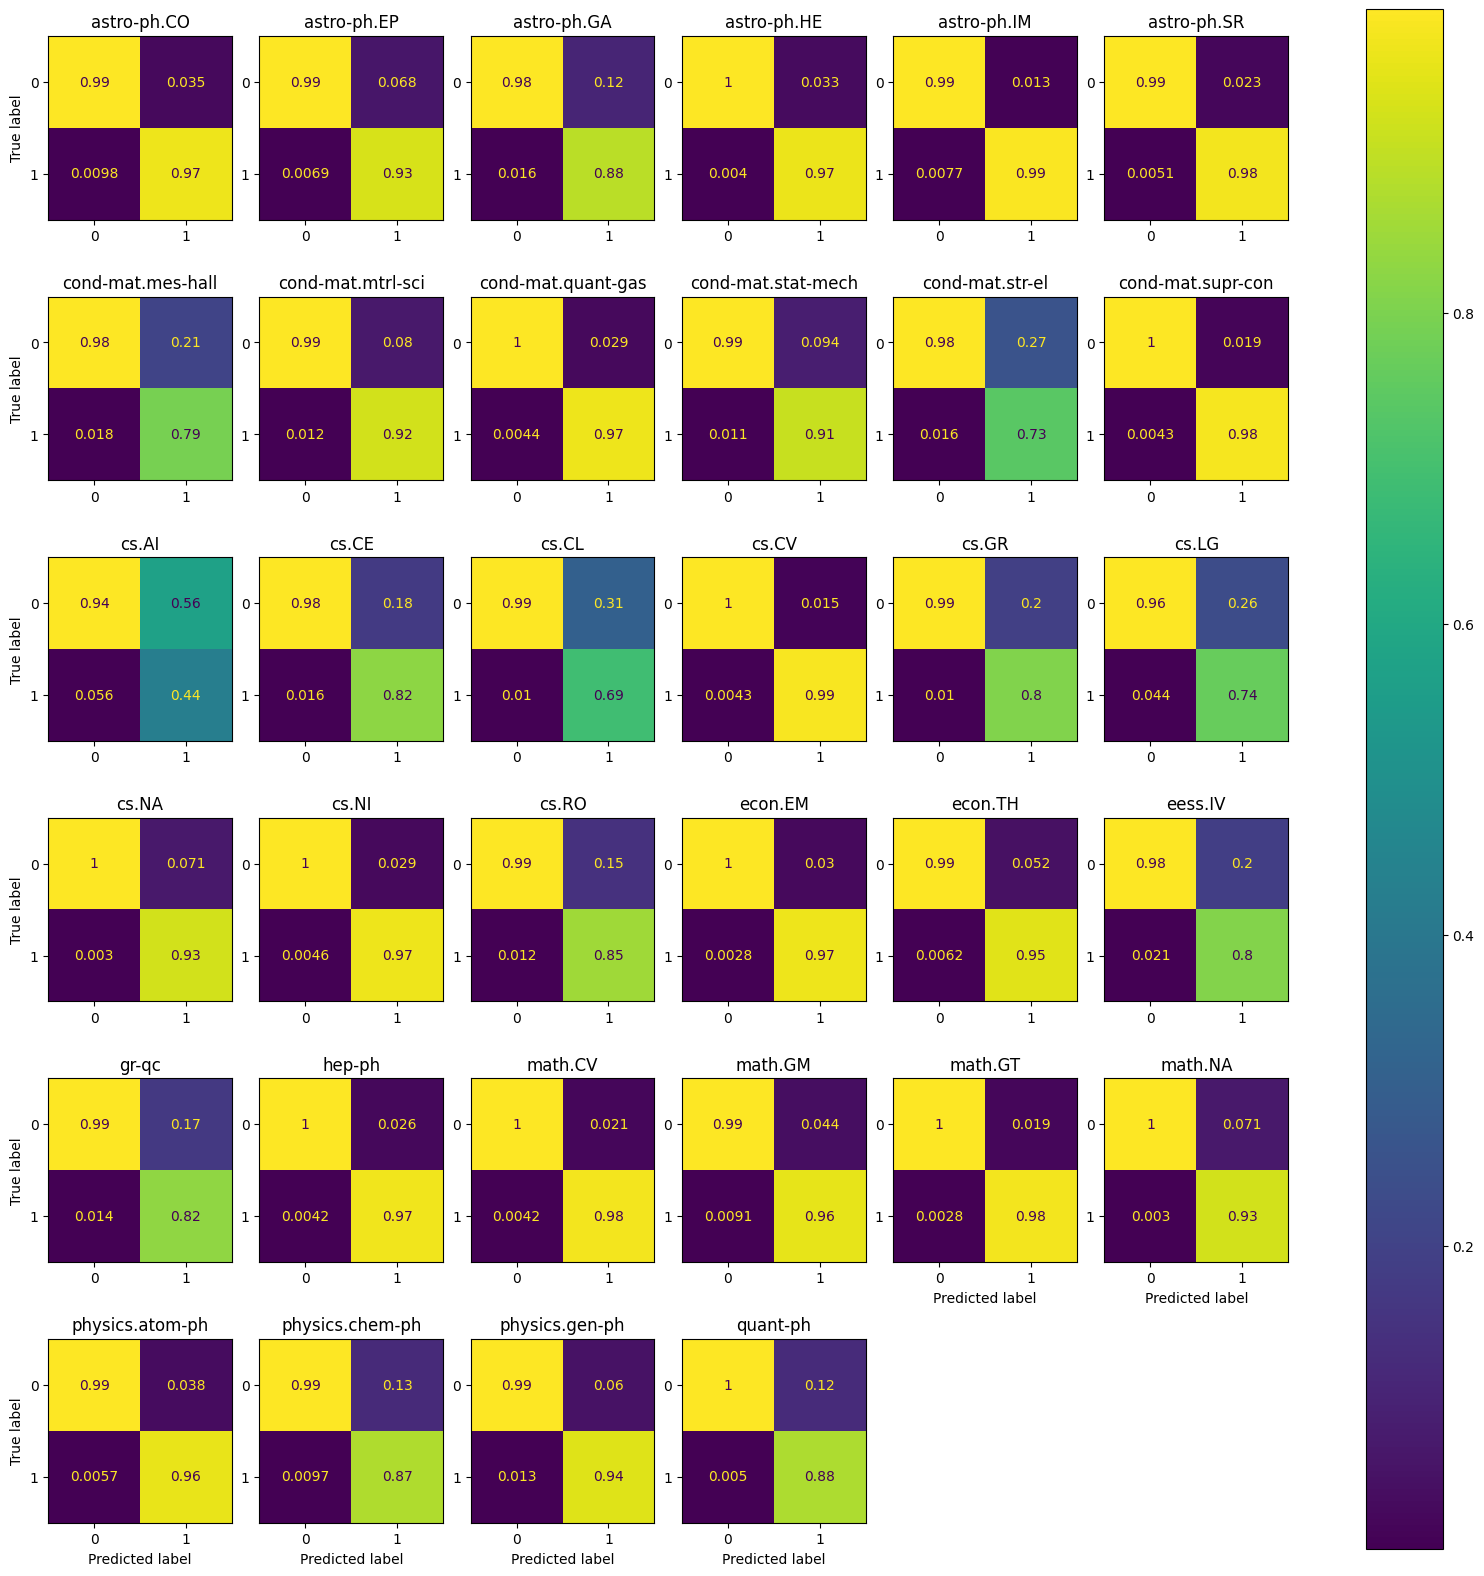

In [ ]:
num_mat = len(mat) # number of confusion matrices we want to plot

# find the number of cells in the grid that will contain the num_mat subplots
num_rows = ceil(np.sqrt(num_mat))
num_cols = ceil(num_mat/num_rows)
num_cells = num_rows*num_cols
rest = num_cells - num_mat


fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,20))
axes = axes.ravel() # get flattened axes

# Iterate over the cells
for i in range(num_cells):

    if i < num_mat:
        # Plot the matrix.
        disp = ConfusionMatrixDisplay(normalize(mat[i], axis=0, norm='l1'))
        disp.plot(ax=axes[i])
        disp.ax_.set_title(f'{classes[i]}')

        # Only show x and y labels for the plots in the border
        first_i_of_last_row = num_rows*num_cols - num_cols
        if i < first_i_of_last_row - rest:
            disp.ax_.set_xlabel('') # Do not set the x label

        is_i_in_first_col = i%num_cols == 0
        if is_i_in_first_col == False:
            disp.ax_.set_ylabel('') # Do not set the y label

        disp.im_.colorbar.remove() # remove it to put it after

    else: # delete axes in excess
        fig.delaxes(axes[i])


plt.subplots_adjust(wspace=0.15, hspace=0.1)
fig.colorbar(disp.im_, ax=axes)
plt.show()

In [ ]:
# Show some predictions
yy_test = mlb.inverse_transform(y_test)
yy_pred = mlb.inverse_transform(y_pred)

for yt, yp in zip(yy_test, yy_pred):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")

Output streaming troncato alle ultime 5000 righe.
  true   : ('astro-ph.CO', 'astro-ph.GA')
predicted: ('astro-ph.CO', 'astro-ph.GA')
--------------------
  true   : ('cs.AI', 'cs.CV')
predicted: ('cs.CV', 'cs.LG')
--------------------
  true   : ('astro-ph.CO', 'astro-ph.GA')
predicted: ('astro-ph.CO', 'astro-ph.GA')
--------------------
  true   : ('cond-mat.mtrl-sci',)
predicted: ('cond-mat.mtrl-sci',)
--------------------
  true   : ('astro-ph.SR',)
predicted: ('astro-ph.SR',)
--------------------
  true   : ('physics.gen-ph',)
predicted: ('physics.gen-ph',)
--------------------
  true   : ('math.GT',)
predicted: ('math.GT',)
--------------------
  true   : ('cs.AI', 'cs.CV', 'cs.LG')
predicted: ('cs.CV', 'cs.LG')
--------------------
  true   : ('cond-mat.mtrl-sci',)
predicted: ('cond-mat.mtrl-sci', 'cond-mat.str-el')
--------------------
  true   : ('cs.CV', 'cs.LG', 'eess.IV')
predicted: ('cs.CV',)
--------------------
  true   : ('astro-ph.GA', 'astro-ph.SR')
predicted: ('astro

## ROC curve

In [ ]:
n_classes = len(classes)

y_score = SVM_pipeline.fit(X_train, y_train).decision_function(X_test)

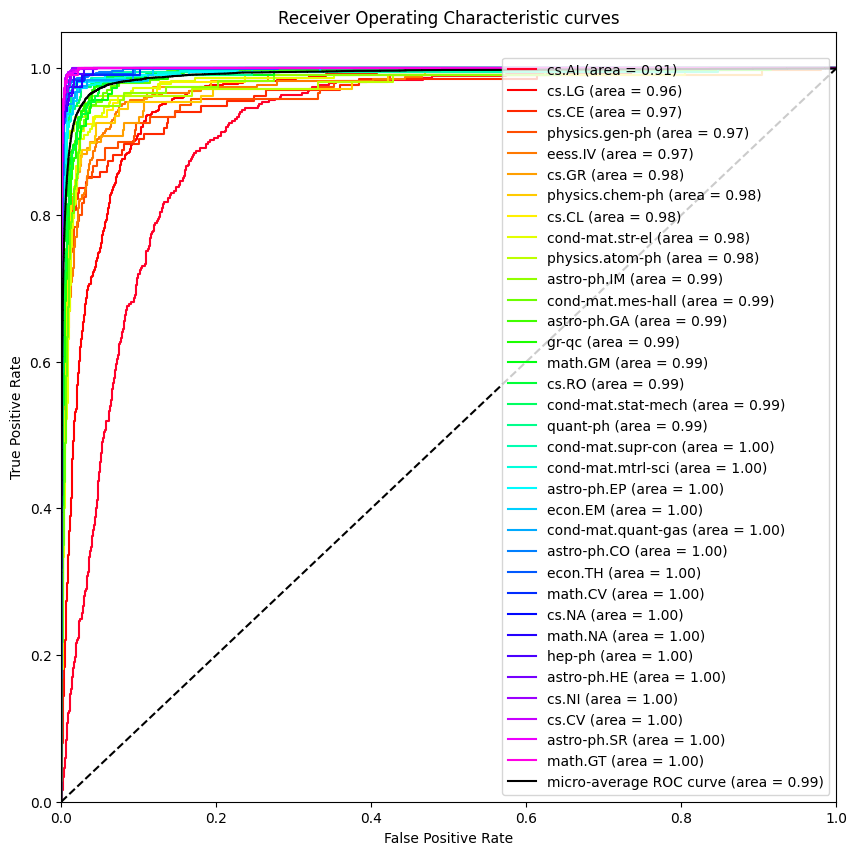

In [ ]:
##### Compute ROC curve and ROC area for each class #####
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Sort the dictionary based on the area value
roc_auc_ord = dict(sorted(roc_auc.items(), key=lambda item: item[1]))

# Take the sorted indices
indici = list(roc_auc_ord.keys())

##### Plot ROC curve #####
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle('color', [cm(1.*i/n_classes) for i in range(n_classes)])

for i in indici:
    ax.plot(fpr[i], tpr[i], label='{0} (area = {1:0.2f})'
                                   ''.format(classes[i], roc_auc[i]))


###### Compute micro-average ROC curve and ROC area #####
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

ax.plot(fpr["micro"], tpr["micro"], color='k',
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))

ax.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curves')
plt.legend(loc="lower right")
plt.show()

# 3) Keywords extraction

In [ ]:
!pip install keyphrase-vectorizers -q
!pip install sematch -q
!pip install nltk -q
!pip install KeyBERT -q
!pip install -U spacy -q # spacy package to preprocess the abstract text
!python -m spacy download en_core_web_sm -q
!pip install neattext -q
!pip install pydetex -U -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.5/363.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.8/772.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 44.1

In [ ]:
import neattext.functions as nfx
from sklearn.feature_extraction.text import TfidfVectorizer
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer
import spacy
import string
import en_core_web_sm
from functools import reduce
from tqdm import tqdm
from pydetex.pipelines import strict

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Texts processing

In [ ]:
nlp = spacy.load("en_core_web_sm")

def remove(text):
    """
    After tokenizing the text, remove punctuation and other characters.

    Arguments
    ---------
       text: str, text to be processed

    Returns
    -------
       filtered_text: str, processed text
    """

    tokens = nlp(text)
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens] # transform to lowercase and then split the text
    B = ["github.com", "http"] # remove the tokens that contains those strings
    filtered_text = [word for word in tokens if not any(bad in word for bad in B)] # filtered_text must be a list of words
    filtered_text = " ".join(c for c in filtered_text if c.isalpha() or c.isspace()) # remove the numeric charcaters
    filtered_text = re.sub('(?:\s)http[^, ]*', '', filtered_text) # remove the words that begin with http (filtered_text must be a string)
    filtered_text = filtered_text.replace("- ", "")  # join the words that are hyphenated

    return filtered_text

In [ ]:
# Remove stop words and apply the remove function
tqdm.pandas()
df["abstract_processed"] = df["abstract"].progress_apply(nfx.remove_stopwords).progress_apply(remove)
df["title_processed"] = df["title"].progress_apply(nfx.remove_stopwords).progress_apply(remove)
df.tail()

100%|██████████| 18475/18475 [02:07<00:00, 145.37it/s]


,id,title,category,abstract,text_to_process,abstract_processed,title_processed
59842,2309.07167,Many boson quantum Szilard engine for fraction...,"[quant-ph, cond-mat.stat-mech]","In this article, we have realized the quantu...",Many boson quantum Szilard engine for fraction...,article realize quantum szilard engine qze non...,boson quantum szilard engine fractional power ...
59843,2112.01099,Equilibration of Multitime Quantum Processes i...,"[quant-ph, cond-mat.stat-mech]",A generic non-integrable (unitary) out-of-eq...,Equilibration of Multitime Quantum Processes i...,generic non integrable unitary out of equilibr...,equilibration multitime quantum processes fini...
59844,2309.12393,Constraining work fluctuations of non-Hermitia...,"[quant-ph, cond-mat.stat-mech]",Thermodynamics constrains changes to the ene...,Constraining work fluctuations of non-Hermitia...,thermodynamic constrain change energy system d...,constrain work fluctuation non hermitian dynam...
59845,2011.11589,Joint statistics of work and entropy productio...,"[quant-ph, cond-mat.stat-mech]","In thermodynamics, entropy production and wo...",Joint statistics of work and entropy productio...,thermodynamic entropy production work quantify...,joint statistic work entropy production quantu...
59846,2110.06963,Finite-time teleportation phase transition in ...,"[quant-ph, cond-mat.stat-mech]",How long does it take to entangle two distan...,Finite-time teleportation phase transition in ...,long entangle distant qubit quantum circuit ev...,finite time teleportation phase transition ran...


In [ ]:
# Add a space to separate title and abstract
df["title_processed"] = df["title_processed"].astype(str) + " "
df["TEXT"] = df["title_processed"] + df["abstract_processed"]

# Save to csv
df.to_csv(f"/content/drive/MyDrive/processed_dataframe.csv", index=False)
df.head()

,id,title,category,abstract,text_to_process,abstract_processed,title_processed,TEXT
0,2212.08056,A multi-tracer empirically-driven approach to ...,"[astro-ph.CO, astro-ph.GA]",Line-intensity mapping (LIM) is an emerging ...,A multi-tracer empirically-driven approach to ...,line intensity mapping lim emerge technique pr...,multi tracer empirically drive approach line i...,multi tracer empirically drive approach line i...
1,2310.11502,Modeling Post-Reionization HI Distributions in...,"[astro-ph.CO, astro-ph.GA]",Upcoming 21 cm intensity mapping experiments...,Modeling Post-Reionization HI Distributions in...,upcome cm intensity mapping experiment like sq...,model post reionization hi distribution fuzzy ...,model post reionization hi distribution fuzzy ...
2,2306.03127,Improved Modeling of the Kinematic Sunyaev-Zel...,"[astro-ph.CO, astro-ph.GA]","Over the past decade, the kinematic Sunyaev-...",Improved Modeling of the Kinematic Sunyaev-Zel...,past decade kinematic sunyaev ksz effect emerg...,improve modeling kinematic sunyaev projected f...,improve modeling kinematic sunyaev projected f...
3,2310.03077,On the ellipticity parameterization for an NFW...,"[astro-ph.CO, astro-ph.GA]",Galaxy-scale gravitational lenses are often ...,On the ellipticity parameterization for an NFW...,galaxy scale gravitational lense model two com...,ellipticity parameterization nfw profile overl...,ellipticity parameterization nfw profile overl...
4,2309.05758,Zero Metallicity with Zero CPU Hours: Masses o...,"[astro-ph.CO, astro-ph.GA]",We develop an analytic model for the mass of...,Zero Metallicity with Zero CPU Hours: Masses o...,develop analytic model mass star form center p...,zero metallicity zero cpu hour masses stars la...,zero metallicity zero cpu hour masses stars la...


## Extract the keywords

In [ ]:
kw_model = KeyBERT('all-mpnet-base-v2')
def extract_kws(TEXT, seed, max_n_grams=1):
    """
    Extract a list of 4 keywords for each input text.

    Arguments
    ---------
       TEXT: text from which to extract keywords
       seed: seed keywords that might guide the extraction of keywords
             by steering the similarities towards the seeded keywords.
       max_n_grams: lenght of the keyword

    Returns
    -------
       keywords: list of extracted keywords for each text
    """
    data = kw_model.extract_keywords(docs=TEXT,
                                      keyphrase_ngram_range=(1,max_n_grams),
                                      seed_keywords = seed,
                                      stop_words='english',
                                      use_mmr=True,
                                      top_n=4) # number of keywords
    keywords = list(list(zip(*data))[0])
    return keywords


# Apply keyword extraction to the data.
tqdm.pandas()
df2 = df.copy(deep=False)
extraction = lambda x: extract_kws(x["TEXT"], x["title_processed"].split(" "))
df2["keywords"] = df2.progress_apply(extraction, axis=1)
df2.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

 17%|█▋        | 3193/18475 [06:23<30:33,  8.33it/s]


KeyboardInterrupt: 

In [ ]:
df2.to_csv(f"/content/drive/MyDrive/keywords.csv", index=False) # Save to csv

# 4) Classification X=kws, y=cat


In [ ]:
df = df2.copy(deep=False)
df.head()

,id,title,category,abstract,text_to_process,abstract_processed,title_processed,TEXT,keywords
6302,2403.07574,Direct observation of strong t-e orbital hybri...,"[cond-mat.mes-hall, cond-mat.str-el]",Recent research has revealed that the Cr fam...,Direct observation of strong t-e orbital hybri...,recent research reveal cr family perovskite ex...,direct observation strong t e orbital hybridiz...,direct observation strong t e orbital hybridiz...,"[antiferromagnetic, perovskite, orbital, hybri..."
60889,2404.00319,Direction Preferring Confidence Intervals,"[stat.ME, stat.AP]",Confidence intervals (CIs) are instrumental ...,Direction Preferring Confidence Intervals Con...,confidence interval ci instrumental statistica...,direction prefer confidence intervals,direction prefer confidence intervals confiden...,"[statistic, coverage, intervals, direction]"
60801,2401.07221,Type I multivariate P\'olya-Aeppli distributio...,"[stat.ME, stat.AP]",An extensive body of literature exists that ...,Type I multivariate P\'olya-Aeppli distributio...,extensive body literature exist specifically a...,type multivariate aeppli distribution applicat...,type multivariate aeppli distribution applicat...,"[multivariate, distribution, aeppli, overdispe..."
60244,2310.16428,Similarity-driven and Task-driven Models for D...,[stat.AP],The recent boom in crowdsourcing has opened ...,Similarity-driven and Task-driven Models for D...,recent boom crowdsourcing open new avenue util...,similarity drive task drive models diversity o...,similarity drive task drive models diversity o...,"[crowdsourcing, similarity, diversity, drive]"
2812,2302.02376,Clustercentric distance or local density? It d...,[astro-ph.GA],Determining which between projected local de...,Clustercentric distance or local density? It d...,determine project local density distance clust...,clustercentric distance local density depend g...,clustercentric distance local density depend g...,"[clustercentric, galaxy, density, morphology]"


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/keywords.csv", dtype=str)
print(f"The dataset contains {len(df)} articles.")

# Preparing X (features)
X = df["keywords"]


df["category"] =  df["category"].map(eval)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["category"])
classes = mlb.classes_ # names of the columns of the one-hot-encoding

#Split data into train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=42)

The dataset contains 10000 articles.


In [ ]:
y_df = pd.DataFrame(y, columns=classes)
y_df

,astro-ph.CO,astro-ph.GA,astro-ph.HE,astro-ph.IM,astro-ph.SR,cond-mat.mes-hall,cond-mat.mtrl-sci,cond-mat.str-el,cond-mat.supr-con,cs.CE,...,math.MP,math.NA,math.NT,math.PR,math.RA,physics.app-ph,physics.optics,quant-ph,stat.AP,stat.ME
0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_pred, mat = run_SVM_pipeline(SVM_pipeline, X_train, X_test, y_train, y_test)
print('accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=classes))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


accuracy:  0.4225
                   precision    recall  f1-score   support

      astro-ph.CO       0.70      0.63      0.66       164
      astro-ph.GA       0.96      0.91      0.93       513
      astro-ph.HE       0.74      0.44      0.55        98
      astro-ph.IM       0.79      0.45      0.57        94
      astro-ph.SR       0.77      0.62      0.69       168
cond-mat.mes-hall       0.66      0.40      0.50        72
cond-mat.mtrl-sci       0.48      0.25      0.33        87
  cond-mat.str-el       0.90      0.84      0.87       334
cond-mat.supr-con       0.74      0.84      0.79        82
            cs.CE       0.67      0.09      0.16        89
            cs.CV       0.81      0.70      0.75       304
            cs.DS       0.83      0.39      0.53        90
            cs.GT       0.83      0.51      0.63        88
            cs.IT       0.89      0.64      0.75       202
            cs.LG       0.51      0.23      0.32       101
            cs.NA       0.72      0.3

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Print the confusion matrices

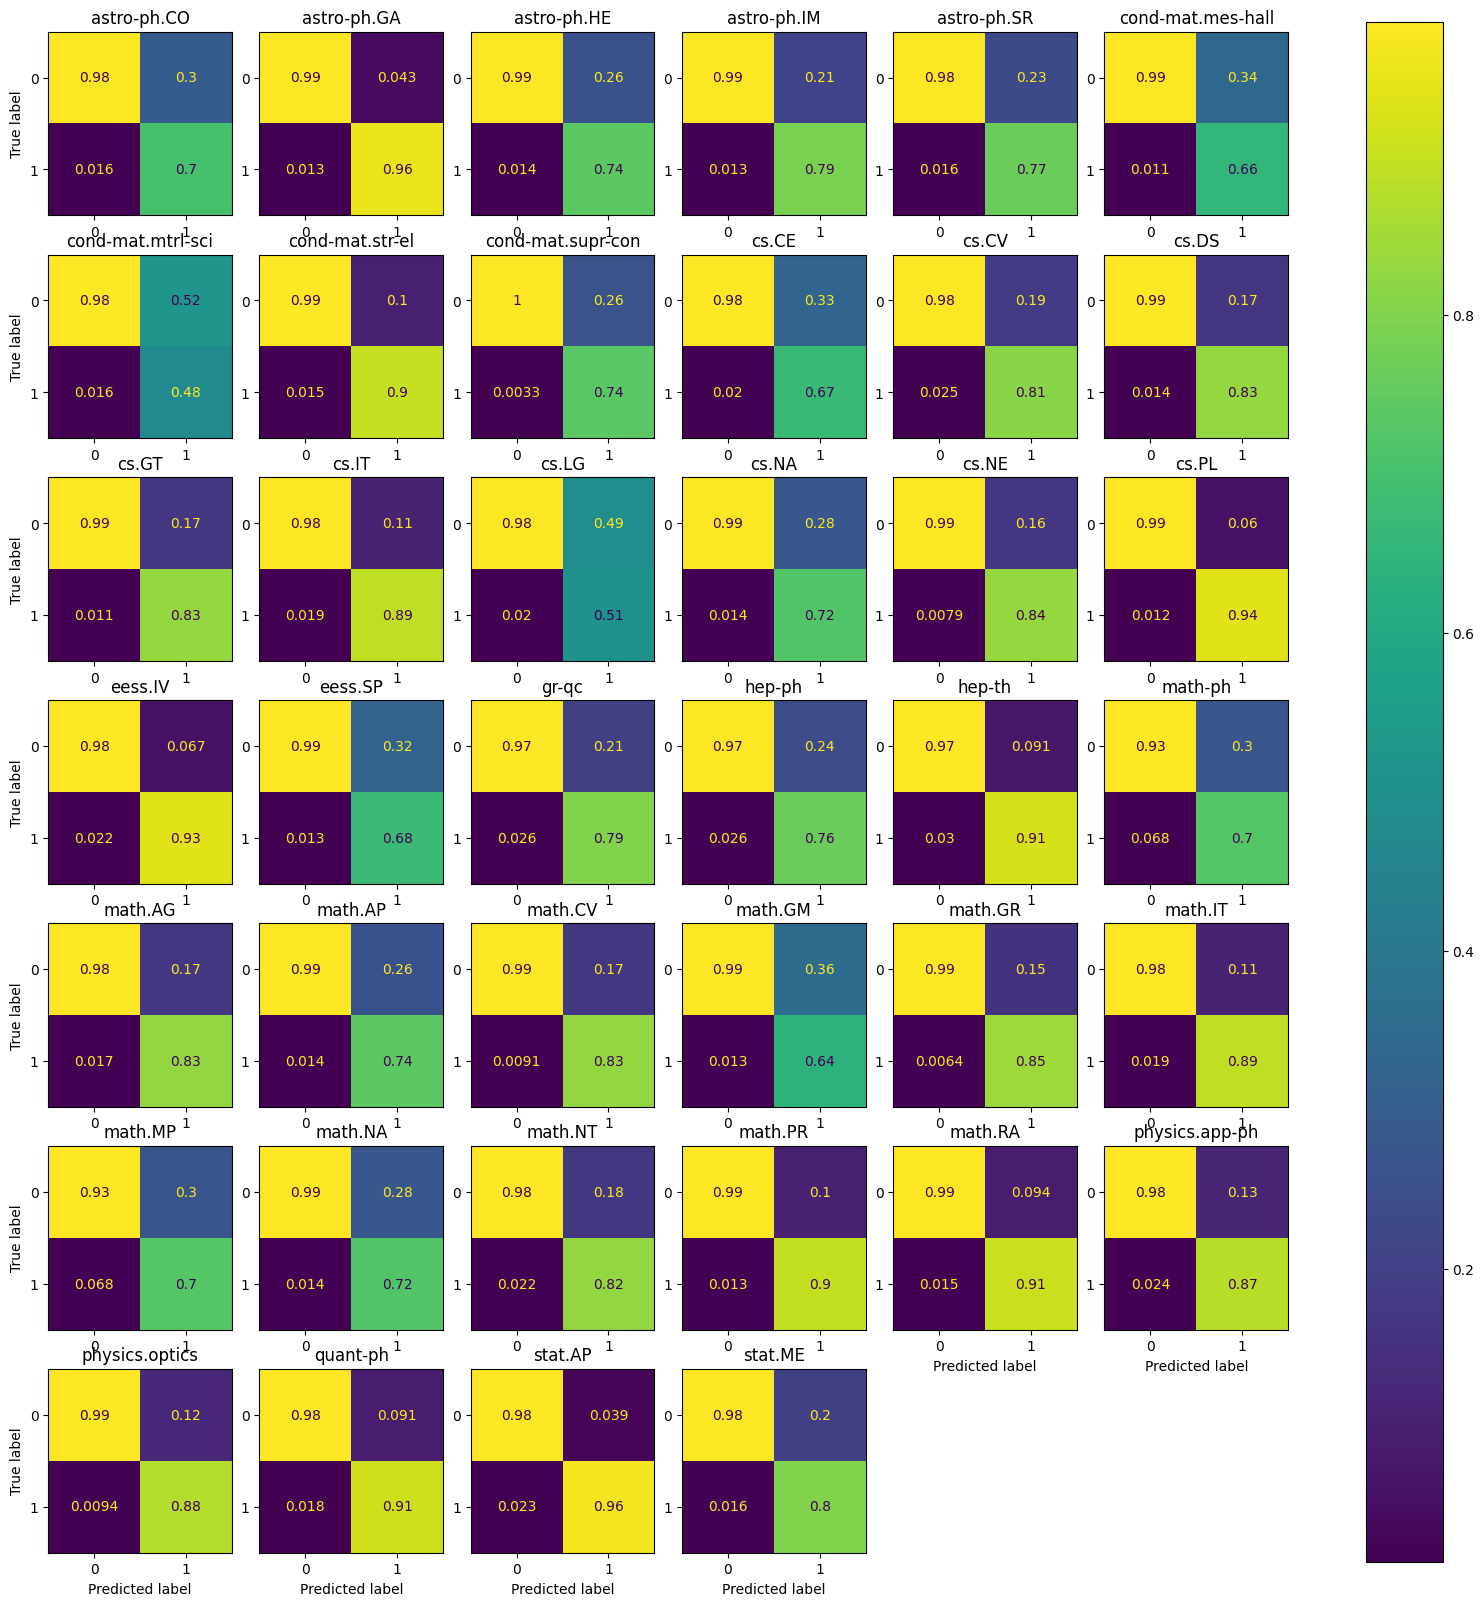

In [ ]:
num_mat = len(mat) # number of confusion matrices we want to plot

# find the number of cells in the grid that will contain the num_mat subplots
num_rows = ceil(np.sqrt(num_mat))
num_cols = ceil(num_mat/num_rows)
num_cells = num_rows*num_cols
rest = num_cells - num_mat


fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,20))
axes = axes.ravel() # get flattened axes

# Iterate over the cells
for i in range(num_cells):

    if i < num_mat:
        # Plot the matrix.
        disp = ConfusionMatrixDisplay(normalize(mat[i], axis=0, norm='l1'))
        disp.plot(ax=axes[i])
        disp.ax_.set_title(f'{classes[i]}')

        # Only show x and y labels for the plots in the border
        first_i_of_last_row = num_rows*num_cols - num_cols
        if i < first_i_of_last_row - rest:
            disp.ax_.set_xlabel('') # Do not set the x label

        is_i_in_first_col = i%num_cols == 0
        if is_i_in_first_col == False:
            disp.ax_.set_ylabel('') # Do not set the y label

        disp.im_.colorbar.remove() # remove it to put it after

    else: # delete axes in excess
        fig.delaxes(axes[i])


plt.subplots_adjust(wspace=0.15, hspace=0.1)
fig.colorbar(disp.im_, ax=axes)
plt.show()

In [ ]:
# Show some predictions
yy_test = mlb.inverse_transform(y_test)
yy_pred = mlb.inverse_transform(y_pred)

for i, (yt, yp) in enumerate(zip(yy_test, yy_pred)):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")
  if(i == 10): continue

NameError: name 'mlb' is not defined

## ROC curve

In [ ]:
n_classes = len(classes)

y_score = SVM_pipeline.fit(X_train, y_train).decision_function(X_test)

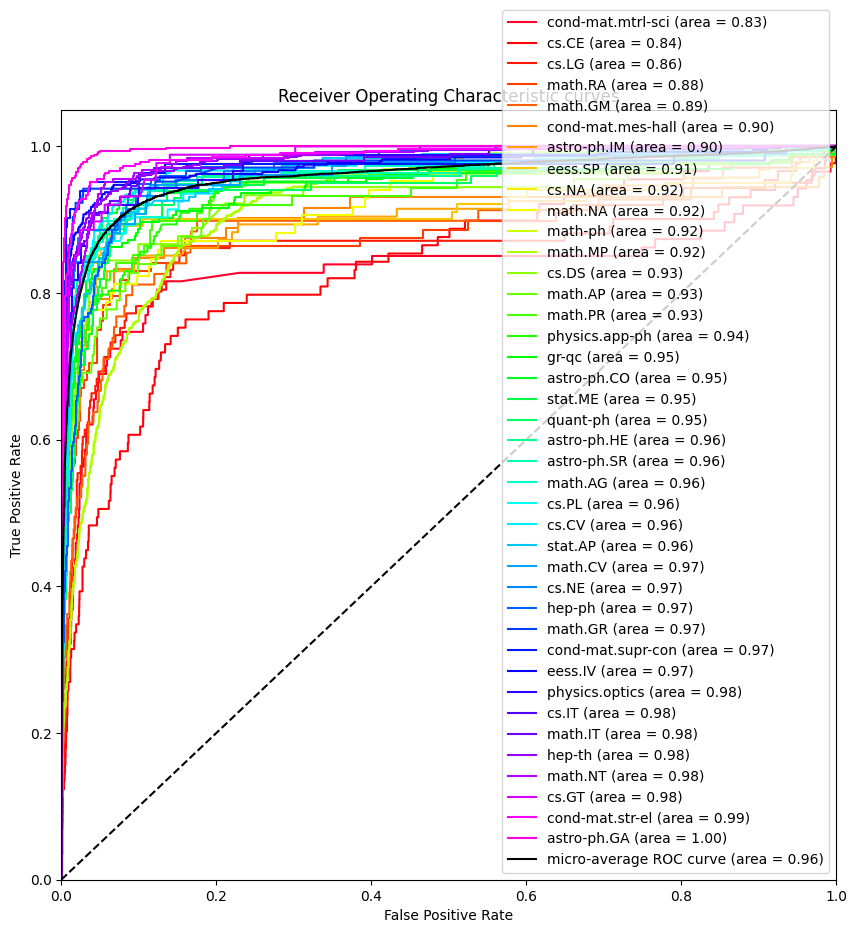

In [ ]:
##### Compute ROC curve and ROC area for each class #####
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Sort the dictionary based on the area value
roc_auc_ord = dict(sorted(roc_auc.items(), key=lambda item: item[1]))

# Take the sorted indices
indici = list(roc_auc_ord.keys())


##### Plot ROC curve #####
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle('color', [cm(1.*i/n_classes) for i in range(n_classes)])

for i in indici:
    ax.plot(fpr[i], tpr[i], label='{0} (area = {1:0.2f})'
                                   ''.format(classes[i], roc_auc[i]))


###### Compute micro-average ROC curve and ROC area #####
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

ax.plot(fpr["micro"], tpr["micro"], color='k',
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))

ax.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curves')
plt.legend(loc="lower right")
plt.show()